In [1]:
import cryoenv.cryosig as cs
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.auto import tqdm, trange

%config InlineBackend.figure_formats = ['svg']

# spring run - thermal optimization

In [2]:
pars_spring = {
    'C': np.array([0.03735771, 0.36706188]),
    'Gb': np.array([0.3 , 0.04]),
    'G': np.array([[ 0. , 17.5],
         [17.5,  0. ]]),
    'lamb': np.array([0.00244, 0.00244]),
    'lamb_tp': np.array([0.003]),
    'eps': np.array([[0.2, 0.8],
         [0.2, 0.8]]),
    'delta': np.array([[1., 0.]]),
    'delta_h': np.array([[1., 0.]]),
    'Rs': np.array([0.04]),
    'Rh': np.array([10.]),
    'L': np.array([1.3e-06]),
    'Rt0': np.array([0.29]),
    'k': np.array([3.10344828]),
    'Tc': np.array([32.6]),
    'Ib': np.array([1.]),
    'dac': np.array([1.485]),
    'pulser_scale': np.array([0.1]),
    'heater_current': np.array([2.]),
    'eta': np.array([16.66666667]),
    'tes_flag': np.array([ True, False]),
    'heater_flag': np.array([ True, False]),
    'i_sq': np.array([1.2]),
    'tes_fluct': np.array([0.005]),
    'flicker_slope': np.array([0.1]),
    'emi': np.array([[0., 0., 0.]]),
    'tau_cap': np.array([1.]),
    'Ib_range': (0.0, 17.86),
    'excess_johnson': np.array([3.]),
    'lowpass': 10000.0,
    'record_length': 32768,
    'sample_frequency': 200001,
    't0': 0.04096,
    'tp_interval': 10,
    'adjust_heatcap': False,
}

In [3]:
det = cs.DetectorModel(**pars_spring)  

In [4]:
det.solve_dac(R_op=0.12, limits=(0.,10.))

1.4851869933615023

In [5]:
det.set_control(dac=[1.485], Ib=[1.], norm=False)  # 1.865

det.wait(50)

det.trigger(er=np.array([0., 6.]), tpa=np.array([0.0])) 

print(det.ph)
print(det.T[-1])

T0 is [32.4973934  32.45749057] mK.
Calculated in 0.5938780307769775 s.
Generated noise in 0.011353015899658203 s.
[0.03666879]
[32.49950556 32.45963602]


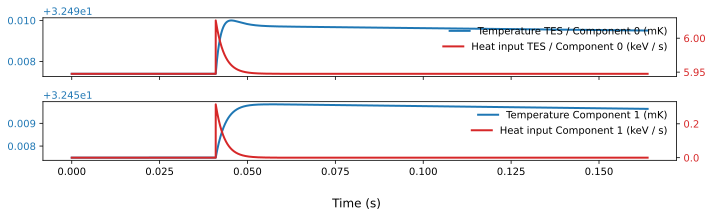

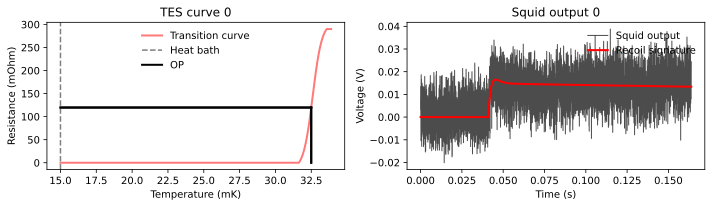

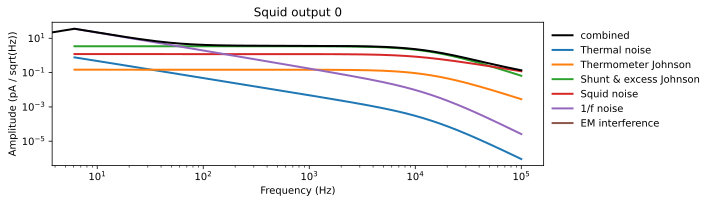

In [6]:
det.plot_temperatures()

det.plot_tes() 

det.plot_nps()  

In [7]:
therm_max = np.max(det.T[:,0]) - det.T[0,0]
abs_max = np.max(det.T[:,1]) - det.T[0,1]
print('therm_max, abs_max = ', therm_max, abs_max) 

therm_max, abs_max =  0.002605513171225482 0.002344622807676444


In [8]:
_, tau_in_, tau_t_ = det.get_thermal_time_constants()
print('tau_in_, tau_t_ = ', tau_in_, tau_t_)
print('f_c_in_, f_c_t_ = ', 1/(2*tau_in_*np.pi), 1/(2*tau_t_*np.pi))

tau_in_, tau_t_ =  0.0019098043985505382 1.1779938262617844
f_c_in_, f_c_t_ =  83.3357296761319 0.1351067718215074


In [9]:
An_, At_, An_a_, At_a_ = det.get_thermal_amplitudes(er=60.)
print('An_, At_, An_a_, At_a_ = ', An_, At_, An_a_, At_a_)

An_, At_, An_a_, At_a_ =  0.10110989854450984 0.023443587339692998 -0.010130749002485057 0.02381316653346506


In [10]:
print('Amplitude descrepancy thermometer: ', (An_ + At_)/therm_max)

Amplitude descrepancy thermometer:  47.803821243252486


In [11]:
print('Amplitude descrepancy absorber: ', (An_a_ + At_a_)/abs_max)

Amplitude descrepancy absorber:  5.835658292746662


In [12]:
pulse = det.Il.flatten() - det.Il[0]
Tt = det.T[0, 0]
It = det.It[0, 0]
w, nps = det.get_nps(Tt, It)

In [13]:
pulse_fft = np.abs(np.fft.rfft(pulse)) ** 2
pulse_fft *= 2 / det.sample_frequency / det.sample_frequency  # need to argue this normalization!

In [14]:
print('SNR of optimally filtered 1 keV pulse: {:.3}'.format(np.sqrt(np.trapz(pulse_fft[1:]/6**2/nps[1:], w[1:]))))

SNR of optimally filtered 1 keV pulse: 2.08


In [15]:
print('Energy resolution, optimally filtered: {:.3} keV'.format(1/(np.sqrt(np.trapz(pulse_fft[1:]/6**2/nps[1:], w[1:])))))

Energy resolution, optimally filtered: 0.481 keV


## scaling props

In [16]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [17]:
def calc_resolution(er_keV, 
                    Ce_ref,
                    Ca_ref,
                    T_op, 
                    T_op_ref, 
                    Tb,
                    tc,
                    Geb, 
                    Gab,
                    Gae,
                    colleff_ref,
                    lamb_ref, 
                    area_tes,  # area_tes would also include Al collectors
                    area_tes_ref,  
                    thickness_tes,  
                    thickness_tes_ref,  
                    vol_absorber, 
                    vol_absorber_ref, 
                    surf_absorber, 
                    surf_absorber_ref,
                    debye_temp, 
                    debye_temp_ref,
                    do_plot=False, 
                    pars_det={},
                   ):
    
    tau_crystal = lamb_ref / (1 - colleff_ref) * (debye_temp_ref/debye_temp) * (surf_absorber_ref/surf_absorber) * (vol_absorber/vol_absorber_ref)
    # print(tau_crystal)
    if colleff_ref > 0:
        tau_film = lamb_ref / colleff_ref * (vol_absorber/vol_absorber_ref) * (area_tes_ref/area_tes) * (debye_temp_ref/debye_temp) * (T_op_ref/T_op)
        eps = 1 / (1 + tau_film/tau_crystal)
        # print(tau_film)
        # print(eps)
    else:
        eps = 0.
    
    if colleff_ref > 0:
        tau_n = 1 / (1/tau_crystal + 1/tau_film)
        # print(tau_n)
    else:
        tau_n = tau_crystal

    det = cs.DetectorModel(C=np.array([Ce_ref * (T_op / T_op_ref) * (area_tes/area_tes_ref) * (thickness_tes/thickness_tes_ref), 
                                       Ca_ref * (T_op / T_op_ref) ** 3 * (vol_absorber/vol_absorber_ref) * (debye_temp_ref/debye_temp) ** 3]),  # scaling to normal conducting TES 
                           Gb=np.array([Geb * (T_op / T_op_ref), 
                                        Gab * (T_op / T_op_ref) ** 3]), 
                           Tb=lambda x: Tb, 
                           G=np.array([[0.   , Gae * (T_op / T_op_ref) ** 5 * (area_tes/area_tes_ref) * (thickness_tes/thickness_tes_ref)],
                                       [Gae * (T_op / T_op_ref) ** 5 * (area_tes/area_tes_ref) * (thickness_tes/thickness_tes_ref), 0.   ]]), 
                           lamb=tau_n*np.ones(2), 
                           eps=np.array([[eps, 1.0 - eps], 
                                         [eps, 1.0 - eps]]), 
                           Tc=np.array([tc + T_op - T_op_ref]),
                           **pars_det,
                          )  
    # print(det.C)
    
    det.solve_dac(R_op=det.Rt[0](T_op), limits=(0., 10.))
    # print(det.T[0,0], det.Rt[0](det.T[0,0]))
    
    det.wait(50)
    
    if do_plot:
        det.trigger(er=np.array([0., er_keV]), tpa=np.array([0.]))
    else:
        with HiddenPrints():
            det.trigger(er=np.array([0., er_keV]), tpa=np.array([0.]))
    
    if do_plot:
        det.plot_temperatures()
        det.plot_tes()
        det.plot_nps()
        
    pulse = det.Il.flatten() - det.Il[0]
    Tt = det.T[0, 0]
    It = det.It[0, 0]
    # print(Tt, It)
    w, nps = det.get_nps(Tt, It)
    # print(np.isnan(pulse))
    
    pulse_fft = np.abs(np.fft.rfft(pulse)) ** 2
    pulse_fft *= 2 / det.sample_frequency / det.sample_frequency  # need to argue this normalization!
    # print(np.isnan(nps))
    # print(np.isnan(pulse_fft))
    
    tau_n, tau_in_, tau_t_ = det.get_thermal_time_constants()
    # print(np.trapz(pulse_fft[1:]/er_keV**2/nps[1:], w[1:]))
    eres = 1/(np.sqrt(np.trapz(pulse_fft[1:]/er_keV**2/nps[1:], w[1:])))
    return eres, tau_n, tau_in_, tau_t_, eps
    

In [18]:
pars_func_spring = {
    'er_keV':6., 
    'Ce_ref':0.03735771,
    'Ca_ref':0.36706188,
    'Geb':0.3, 
    'Gab':0.04,
    'Gae':17.5,
    'colleff_ref':0.2,
    'lamb_ref':0.00244, 
    'T_op':32.5, 
    'T_op_ref':32.5, 
    'Tb':15.,
    'tc': 32.6,
    # 'R_target':0.12,
    'area_tes':2,  # area_tes would also include Al collectors
    'area_tes_ref':2,  
    'thickness_tes':8,  
    'thickness_tes_ref':8,  
    'vol_absorber':1000, 
    'vol_absorber_ref':1000, 
    'surf_absorber':600, 
    'surf_absorber_ref':600,
    'debye_temp':165000, 
    'debye_temp_ref':165000,
}

In [19]:
pars_det_spring = {
    'delta': np.array([[1., 0.]]),
    'delta_h': np.array([[1., 0.]]),
    'Rs': np.array([0.04]),
    'Rh': np.array([10.]),
    'L': np.array([1.3e-06]),
    'Rt0': np.array([0.29]),
    'k': np.array([3.10344828]),
    'Ib': np.array([1.]),
    'dac': np.array([1.485]),
    'pulser_scale': np.array([0.1]),
    'heater_current': np.array([2.]),
    'eta': np.array([16.66666667]),
    'tes_flag': np.array([ True, False]),
    'heater_flag': np.array([ True, False]),
    'i_sq': np.array([1.2]),
    'tes_fluct': np.array([0.005]),
    'flicker_slope': np.array([0.1]),
    'emi': np.array([[0., 0., 0.]]),
    'tau_cap': np.array([1.]),
    'Ib_range': (0.0, 17.86),
    'excess_johnson': np.array([3.]),
    'lowpass': 10000.0,
    'record_length': 32768,
    'sample_frequency': 200001,
    't0': 0.04096,
    'tp_interval': 10,
    'adjust_heatcap': False,
}

In [20]:
# do for 3.6, 28.8, 97.2 g crystals

pars_func_spring_4g = deepcopy(pars_func_spring)
pars_func_spring_4g['vol_absorber'] *= 1 ** 3
pars_func_spring_4g['surf_absorber'] *= 1 ** 2
pars_func_spring_4g['Gab'] *= 1 ** 2

pars_func_spring_29g = deepcopy(pars_func_spring)
pars_func_spring_29g['vol_absorber'] *= 2 ** 3
pars_func_spring_29g['surf_absorber'] *= 2 ** 2
pars_func_spring_29g['Gab'] *= 2 ** 2


pars_func_spring_97g = deepcopy(pars_func_spring)
pars_func_spring_97g['vol_absorber'] *= 3 ** 3
pars_func_spring_97g['surf_absorber'] *= 3 ** 2
pars_func_spring_97g['Gab'] *= 3 ** 2


## temperature down

In [26]:
all_op_temps = []

for setup in [pars_func_spring_4g, pars_func_spring_29g, pars_func_spring_97g]:
    op_temps = []
    for temp in tqdm(np.logspace(np.log10(17.), np.log10(33.), 30)):
        this_setup = deepcopy(setup)
        this_setup['T_op'] = temp
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(pars_det=pars_det_spring, **this_setup)
        op_temps.append([eres, tau_n, tau_in, tau_t, eps_])
    all_op_temps.append(op_temps)

all_op_temps = np.array(all_op_temps)

  0%|          | 0/30 [00:00<?, ?it/s]

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/0y/_zyrlyfn1412ysy20pvh2r8c0000gn/T/ipykernel_14472/116387453.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  eres = 1/(np.sqrt(np.trapz(pulse_fft[1:]/er_keV**2/nps[1:], w[1:])))


In [27]:
np.save('plots_paper/run599_all_op_temps.npy', all_op_temps)

In [21]:
all_op_temps = np.load('plots_paper/run599_all_op_temps.npy')

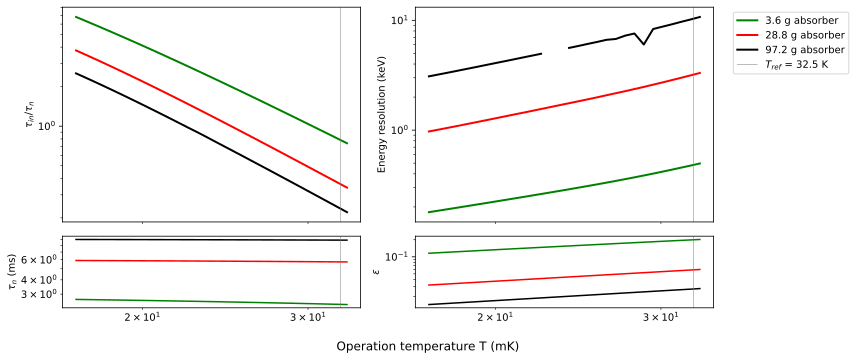

In [22]:
fig, axes = plt.subplots(2,2, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=300)

x_grid = np.logspace(np.log10(17.), np.log10(33.), 30)

axes[0,0].plot(x_grid, all_op_temps[0, :, 2]/all_op_temps[0, :, 1], color='green', linewidth=2.)
axes[0,0].plot(x_grid, all_op_temps[1, :, 2]/all_op_temps[1, :, 1], color='red', linewidth=2.)
axes[0,0].plot(x_grid, all_op_temps[2, :, 2]/all_op_temps[2, :, 1], color='black', linewidth=2.)
axes[0,0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].axvline(32.5, color='grey', linewidth=0.5)

axes[0,1].plot(x_grid, all_op_temps[0, :, 0], color='green', linewidth=2.,
            label="3.6 g absorber")
axes[0,1].plot(x_grid, all_op_temps[1, :, 0], color='red', linewidth=2.,
            label="28.8 g absorber")
axes[0,1].plot(x_grid, all_op_temps[2, :, 0], color='black', linewidth=2.,
            label="97.2 g absorber")
axes[0,1].set_ylabel('Energy resolution (keV)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].axvline(32.5, color='grey', linewidth=0.5, label='$T_{ref}$ = 32.5 K')
axes[0,1].legend(bbox_to_anchor=(1.05, 1.0))

axes[1,0].plot(x_grid, 1000*all_op_temps[0,:,1], color='green', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_op_temps[1,:,1], color='red', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_op_temps[2,:,1], color='black', linewidth=1.5)
axes[1,0].axvline(32.5, color='grey', linewidth=0.5)
axes[1,0].set_ylabel(r'$\tau_n$ (ms)')
axes[1,0].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].plot(x_grid, all_op_temps[0,:,-1], color='green', linewidth=1.5)
axes[1,1].plot(x_grid, all_op_temps[1,:,-1], color='red', linewidth=1.5)
axes[1,1].plot(x_grid, all_op_temps[2,:,-1], color='black', linewidth=1.5)
axes[1,1].axvline(32.5, color='grey', linewidth=0.5)
axes[1,1].set_ylabel(r'$\epsilon$')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')

fig.supxlabel(r'Operation temperature T (mK)')
# fig.suptitle(r"$\tau_n(T_{ref})$ = 2 ms, $C_{a}(T_{ref})$ = 0.038 pJ/mK, $C_{e}(T_{ref})$ = 0.001 pJ/mK, $G_{eb}(T_{ref})$ = 0.04 pW/mK, $G_{ab}(T_{ref})$ = 0.04 pW/mK, $G_{ae}(T_{ref})$ = 17.2 pW/mK, $\epsilon(T_{ref})$ = 0.2")
plt.tight_layout()
plt.savefig('plots_paper/run599_op_temps.png')
plt.show()


In [23]:
print('Resolution 4g in keV: ', all_op_temps[0, :, 0].min(), ' at ', x_grid[all_op_temps[0, :, 0].argmin()])
print('Resolution 29g in keV: ', all_op_temps[1, :, 0].min(), ' at ', x_grid[all_op_temps[1, :, 0].argmin()])
print('Resolution 97g in keV: ', all_op_temps[2, :, 0].min(), ' at ', x_grid[all_op_temps[2, :, 0].argmin()])

Resolution 4g in keV:  0.17903493460231842  at  17.0
Resolution 29g in keV:  0.9730303397831341  at  17.0
Resolution 97g in keV:  3.09082461498142  at  17.0


## optimize gold size

In [24]:
# do for 3.6, 28.8, 97.2 g crystals

pars_func_spring_4g = deepcopy(pars_func_spring)
pars_func_spring_4g['vol_absorber'] *= 1 ** 3
pars_func_spring_4g['surf_absorber'] *= 1 ** 2
pars_func_spring_4g['T_op'] = 17. 
pars_func_spring_4g['Gab'] *= 1 ** 2

pars_func_spring_29g = deepcopy(pars_func_spring)
pars_func_spring_29g['vol_absorber'] *= 2 ** 3
pars_func_spring_29g['surf_absorber'] *= 2 ** 2
pars_func_spring_29g['T_op'] = 17.
pars_func_spring_29g['Gab'] *= 2 ** 2

pars_func_spring_97g = deepcopy(pars_func_spring)
pars_func_spring_97g['vol_absorber'] *= 3 ** 3
pars_func_spring_97g['surf_absorber'] *= 3 ** 2
pars_func_spring_97g['T_op'] = 17.
pars_func_spring_97g['Gab'] *= 3 ** 2


In [32]:
all_gold_sizes = []

for setup in [pars_func_spring_4g, pars_func_spring_29g, pars_func_spring_97g]:
    gold_sizes = []
    for aus in tqdm(np.logspace(np.log10(0.2), np.log10(400.), 30)):
        this_setup = deepcopy(setup)
        this_setup['area_tes'] = aus
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(pars_det=pars_det_spring, **this_setup)
        gold_sizes.append([eres, tau_n, tau_in, tau_t, eps_])
    all_gold_sizes.append(gold_sizes)

all_gold_sizes = np.array(all_gold_sizes)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [33]:
np.save('plots_paper/run599_all_gold_sizes.npy', all_gold_sizes)

In [25]:
all_gold_sizes = np.load('plots_paper/run599_all_gold_sizes.npy')

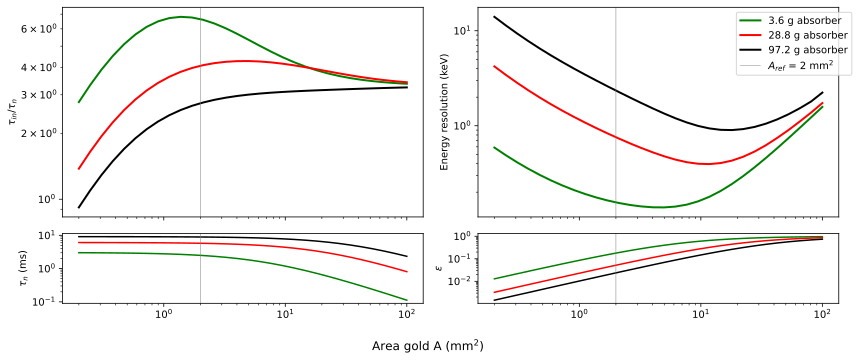

In [29]:
fig, axes = plt.subplots(2,2, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=300)

x_grid = np.logspace(np.log10(0.2), np.log10(100.), 30)

axes[0,0].plot(x_grid, all_gold_sizes[0, :, 2]/all_gold_sizes[0, :, 1], color='green', linewidth=2.)
axes[0,0].plot(x_grid, all_gold_sizes[1, :, 2]/all_gold_sizes[1, :, 1], color='red', linewidth=2.)
axes[0,0].plot(x_grid, all_gold_sizes[2, :, 2]/all_gold_sizes[2, :, 1], color='black', linewidth=2.)
axes[0,0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].axvline(2., color='grey', linewidth=0.5)

axes[0,1].plot(x_grid, all_gold_sizes[0, :, 0], color='green', linewidth=2.,
            label="3.6 g absorber")
axes[0,1].plot(x_grid, all_gold_sizes[1, :, 0], color='red', linewidth=2.,
            label="28.8 g absorber")
axes[0,1].plot(x_grid, all_gold_sizes[2, :, 0], color='black', linewidth=2.,
            label="97.2 g absorber")
axes[0,1].set_ylabel('Energy resolution (keV)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].axvline(2., color='grey', linewidth=0.5, label='$A_{ref}$ = 2 mm$^2$')
axes[0,1].legend(bbox_to_anchor=(1.05, 1.0))

axes[1,0].plot(x_grid, 1000*all_gold_sizes[0,:,1], color='green', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_gold_sizes[1,:,1], color='red', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_gold_sizes[2,:,1], color='black', linewidth=1.5)

axes[1,0].axvline(2., color='grey', linewidth=0.5)
axes[1,0].set_ylabel(r'$\tau_n$ (ms)')
axes[1,0].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].plot(x_grid, all_gold_sizes[0,:,-1], color='green', linewidth=1.5)
axes[1,1].plot(x_grid, all_gold_sizes[1,:,-1], color='red', linewidth=1.5)
axes[1,1].plot(x_grid, all_gold_sizes[2,:,-1], color='black', linewidth=1.5)
axes[1,1].axvline(2., color='grey', linewidth=0.5)
axes[1,1].set_ylabel(r'$\epsilon$')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')

fig.supxlabel(r'Area gold A (mm$^2$)')
# fig.suptitle(r"$\tau_n(T_{ref})$ = 2 ms, $C_{a}(T_{ref})$ = 0.038 pJ/mK, $C_{e}(T_{ref})$ = 0.001 pJ/mK, $G_{eb}(T_{ref})$ = 0.04 pW/mK, $G_{ab}(T_{ref})$ = 0.04 pW/mK, $G_{ae}(T_{ref})$ = 17.2 pW/mK, $\epsilon(T_{ref})$ = 0.2")
plt.tight_layout()
plt.savefig('plots_paper/run599_all_gold_sizes.png')
plt.show()


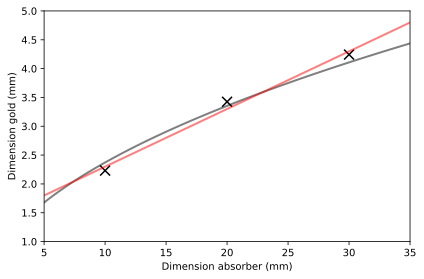

In [27]:
plt.figure(figsize=(6,4), dpi=300)
x_dims = np.array([10, 20, 30])
x_dims_grid = np.linspace(0,35,100)
plt.plot(x_dims_grid, 0.75*np.sqrt(x_dims_grid), color='black', alpha=0.5, linewidth=2)
plt.plot(x_dims_grid, 0.1*x_dims_grid + 1.3, color='red', alpha=0.5, linewidth=2)
plt.scatter(x_dims, np.sqrt([x_grid[15], x_grid[19], x_grid[21]]), marker='x', color='black', s=100)
plt.ylabel('Dimension gold (mm)')
plt.xlabel('Dimension absorber (mm)')
plt.xlim(5,35)
plt.ylim(1,5)
plt.savefig('plots_paper/run599_dimensions.png')
plt.tight_layout()
plt.show()

In [30]:
print('Resolution 4g in keV: ', all_gold_sizes[0, :, 0].min(), ' at ', x_grid[all_gold_sizes[0, :, 0].argmin()])
print('Resolution 29g in keV: ', all_gold_sizes[1, :, 0].min(), ' at ', x_grid[all_gold_sizes[1, :, 0].argmin()])
print('Resolution 97g in keV: ', all_gold_sizes[2, :, 0].min(), ' at ', x_grid[all_gold_sizes[2, :, 0].argmin()])

Resolution 4g in keV:  0.13821703154057136  at  4.977932042408958
Resolution 29g in keV:  0.39488727063105444  at  11.730612480602236
Resolution 97g in keV:  0.9008069292052803  at  18.007629661059447


## extend window - uncertain due to 1/f noise

In [31]:
mock_time = np.linspace(0,6,100000) - 0.5
delta_t = mock_time[1] - mock_time[0]
mock_pulse = np.zeros(mock_time.shape[0])
mock_pulse[mock_time > 0.] = 0.013*np.exp(-(mock_time[mock_time > 0.] - 0.5)/1.2)
mock_noise = np.random.normal(scale=0.006, size=mock_time.shape)

In [85]:
eres = []

for idx in trange(0, 100000, 100):
    records = np.random.normal(size=(100,idx)) + mock_pulse[:idx].reshape(1,idx)
    phs = np.dot(records, mock_pulse[:idx])
    eres.append( np.std(phs)/np.dot(mock_pulse[:idx], mock_pulse[:idx]) )

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/0y/_zyrlyfn1412ysy20pvh2r8c0000gn/T/ipykernel_17839/2176702678.py:6: RuntimeWarning: invalid value encountered in double_scalars
  eres.append( np.std(phs)/np.dot(mock_pulse[:idx], mock_pulse[:idx]) )


In [88]:
np.save('plots_paper/recw_eres.npy', eres)



In [32]:
eres=np.load('plots_paper/recw_eres.npy')



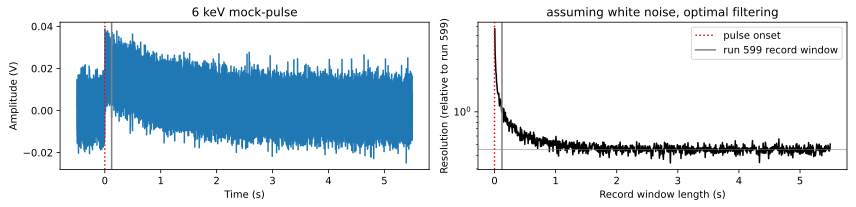

In [33]:
fig, axis = plt.subplots(1,2, figsize=(12,3), dpi=300)

axis[0].plot(mock_time, mock_pulse + mock_noise)
axis[0].axvline(0., color='red', linestyle='dotted', label='pulse onset')
axis[0].axvline(0.122, color='grey', label='run 599 record window')
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Amplitude (V)')
axis[0].set_title('6 keV mock-pulse')

axis[1].plot(np.arange(0, 100000, 100)*delta_t - 0.5, np.array(eres)/eres[104], color='black')
axis[1].axvline(0., color='red', linestyle='dotted', label='pulse onset')
axis[1].axvline(0.122, color='grey', label='run 599 record window')
axis[1].set_xlabel('Record window length (s)')
axis[1].set_ylabel('Resolution (relative to run 599)')
axis[1].set_title('assuming white noise, optimal filtering')
axis[1].legend()
axis[1].set_yscale('log')
axis[1].axhline(0.45, color='grey', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots_paper/recw_eres.png')
plt.show()

## opt thickness TES

In [92]:
# do for 3.6, 28.8, 97.2 g crystals

pars_func_spring_4g = deepcopy(pars_func_spring)
pars_func_spring_4g['vol_absorber'] *= 1 ** 3
pars_func_spring_4g['surf_absorber'] *= 1 ** 2
pars_func_spring_4g['T_op'] = 17. 
pars_func_spring_4g['Gab'] *= 1 ** 2 
pars_func_spring_4g['area_tes'] = 5.

pars_func_spring_29g = deepcopy(pars_func_spring)
pars_func_spring_29g['vol_absorber'] *= 2 ** 3
pars_func_spring_29g['surf_absorber'] *= 2 ** 2
pars_func_spring_29g['T_op'] = 17. 
pars_func_spring_29g['Gab'] *= 2 ** 2 
pars_func_spring_29g['area_tes'] = 11.7 

pars_func_spring_97g = deepcopy(pars_func_spring)
pars_func_spring_97g['vol_absorber'] *= 3 ** 3
pars_func_spring_97g['surf_absorber'] *= 3 ** 2
pars_func_spring_97g['T_op'] = 17. 
pars_func_spring_97g['Gab'] *= 3 ** 2 
pars_func_spring_97g['area_tes'] = 18.


In [299]:
all_thickness = []

for setup in [pars_func_spring_4g, pars_func_spring_29g, pars_func_spring_97g]:
    thickness = []
    for thick in tqdm(np.logspace(np.log10(0.1), np.log10(50.), 30)):
        this_setup = deepcopy(setup)
        this_setup['thickness_tes'] = thick
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(pars_det=pars_det_spring, **this_setup)
        thickness.append([eres, tau_n, tau_in, tau_t, eps_])
    all_thickness.append(thickness)

all_thickness = np.array(all_thickness)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [300]:
np.save('plots_paper/run599_all_thickness.npy', all_thickness)

In [93]:
all_thickness = np.load('plots_paper/run599_all_thickness.npy')

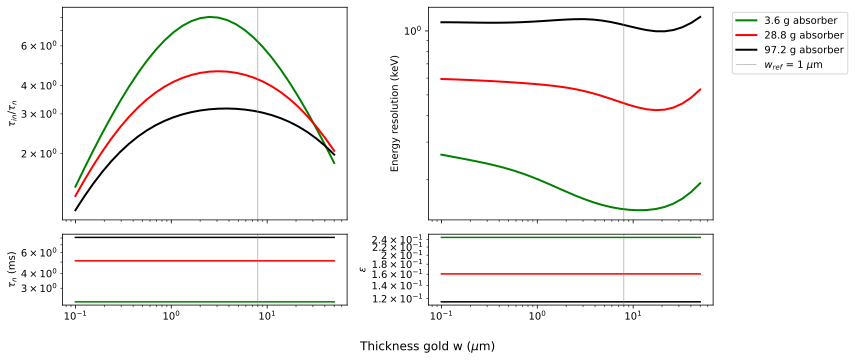

In [94]:
fig, axes = plt.subplots(2,2, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=300)

x_grid = np.logspace(np.log10(0.1), np.log10(50.), 30)

axes[0,0].plot(x_grid, all_thickness[0, :, 2]/all_thickness[0, :, 1], color='green', linewidth=2.)
axes[0,0].plot(x_grid, all_thickness[1, :, 2]/all_thickness[1, :, 1], color='red', linewidth=2.)
axes[0,0].plot(x_grid, all_thickness[2, :, 2]/all_thickness[2, :, 1], color='black', linewidth=2.)
axes[0,0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].axvline(8., color='grey', linewidth=0.5)

axes[0,1].plot(x_grid, all_thickness[0, :, 0], color='green', linewidth=2.,
            label="3.6 g absorber")
axes[0,1].plot(x_grid, all_thickness[1, :, 0], color='red', linewidth=2.,
            label="28.8 g absorber")
axes[0,1].plot(x_grid, all_thickness[2, :, 0], color='black', linewidth=2.,
            label="97.2 g absorber")
axes[0,1].set_ylabel('Energy resolution (keV)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].axvline(8., color='grey', linewidth=0.5, label='$w_{ref}$ = 1 $\mu$m')
axes[0,1].legend(bbox_to_anchor=(1.05, 1.0))

axes[1,0].plot(x_grid, 1000*all_thickness[0,:,1], color='green', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_thickness[1,:,1], color='red', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_thickness[2,:,1], color='black', linewidth=1.5)
axes[1,0].axvline(8., color='grey', linewidth=0.5)
axes[1,0].set_ylabel(r'$\tau_n$ (ms)')
axes[1,0].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].plot(x_grid, all_thickness[0,:,-1], color='green', linewidth=1.5)
axes[1,1].plot(x_grid, all_thickness[1,:,-1], color='red', linewidth=1.5)
axes[1,1].plot(x_grid, all_thickness[2,:,-1], color='black', linewidth=1.5)
axes[1,1].axvline(8., color='grey', linewidth=0.5)
axes[1,1].set_ylabel(r'$\epsilon$')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')

fig.supxlabel(r'Thickness gold w ($\mu$m)')
# fig.suptitle(r"$\tau_n(T_{ref})$ = 2 ms, $C_{a}(T_{ref})$ = 0.038 pJ/mK, $C_{e}(T_{ref})$ = 0.001 pJ/mK, $G_{eb}(T_{ref})$ = 0.04 pW/mK, $G_{ab}(T_{ref})$ = 0.04 pW/mK, $G_{ae}(T_{ref})$ = 17.2 pW/mK, $\epsilon(T_{ref})$ = 0.2")
plt.tight_layout()
plt.savefig('plots_paper/run599_all_thickness.png')
plt.show()


In [87]:
print('Resolution 4g in keV: ', all_thickness[0, :, 0].min(), ' at ', x_grid[all_thickness[0, :, 0].argmin()])
print('Resolution 29g in keV: ', all_thickness[1, :, 0].min(), ' at ', x_grid[all_thickness[1, :, 0].argmin()])
print('Resolution 97g in keV: ', all_thickness[2, :, 0].min(), ' at ', x_grid[all_thickness[2, :, 0].argmin()])

Resolution 4g in keV:  0.14340314183140304  at  11.155639876771923
Resolution 29g in keV:  0.4240691542742209  at  17.124990861751012
Resolution 97g in keV:  0.9959721015731741  at  21.2176987801808


T0 is [17.00008532 16.99475469] mK.
Calculated in 0.9072158336639404 s.
Generated noise in 0.014909029006958008 s.


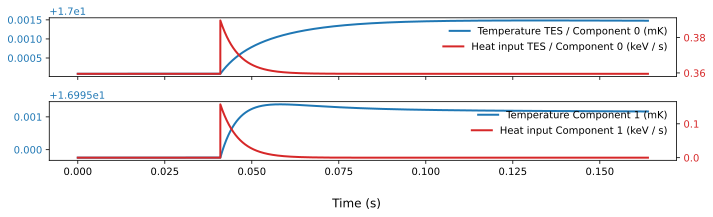

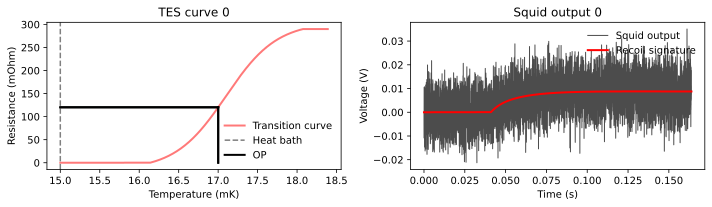

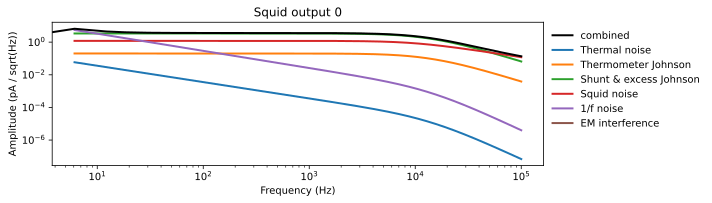

(0.42407758337748963,
 0.005120671563483735,
 0.017887386061948975,
 3.567017390051705,
 0.16054564533053514)

In [88]:
this_setup = deepcopy(pars_func_spring_29g)
this_setup['thickness_tes'] = 17.1

calc_resolution(pars_det=pars_det_spring, do_plot=True, **this_setup)

# Summer run - athermal phonon collection

In [42]:
pars_summer = {'C': np.array([0.00401248, 0.23132998]),
  'Gb': np.array([0.457 , 0.1456]),
  'G': np.array([[0.  , 0.51],
         [0.51, 0.  ]]),
  'lamb': np.array([0.00242, 0.00242]),
  'lamb_tp': np.array([0.003]),
  'eps': np.array([[0.04, 0.96],
         [0.04, 0.96]]),
  'delta': np.array([[1., 0.]]),
  'delta_h': np.array([[1., 0.]]),
  'Rs': np.array([0.04]),
  'Rh': np.array([10.]),
  'L': np.array([1.3e-06]),
  'Rt0': np.array([0.07]),
  'k': np.array([2.85714286]),
  'Tc': np.array([27.85]),
  'Ib': np.array([1.]),
  'dac': np.array([1.88]),
  'pulser_scale': np.array([0.1]),
  'heater_current': np.array([2.]),
  'eta': np.array([6.66666667]),
  'tes_flag': np.array([ True, False]),
  'heater_flag': np.array([ True, False]),
  'i_sq': np.array([1.2]),
  'tes_fluct': np.array([0.009]),
  'flicker_slope': np.array([2.5]),
  'emi': np.array([[0., 0., 0.]]),
  'tau_cap': np.array([1.]),
  'Ib_range': (0.0, 17.86),
  'excess_johnson': np.array([2.]),
  'lowpass': 20000.0,
  'record_length': 32768,
  'sample_frequency': 50001,
  't0': 0.16384,
  'tp_interval': 10}

In [43]:
det = cs.DetectorModel(**pars_summer)  

In [44]:
det.solve_dac(R_op=0.053, limits=(0.,10.))

/Users/felix/.pyenv/versions/3.10.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1.8801108372629858

In [45]:
# det.set_control(dac=[1.88], Ib=[1.], norm=False)  # 1.865

det.wait(20)

det.trigger(er=np.array([0., 6.]), tpa=np.array([0.0])) 

print(det.ph)
print(det.T[-1])

T0 is [28.20549929 25.27273435] mK.
Calculated in 0.1847531795501709 s.
Generated noise in 0.009724140167236328 s.
[0.01582755]
[28.20645494 25.27453161]


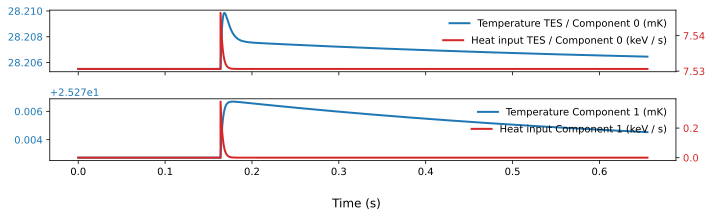

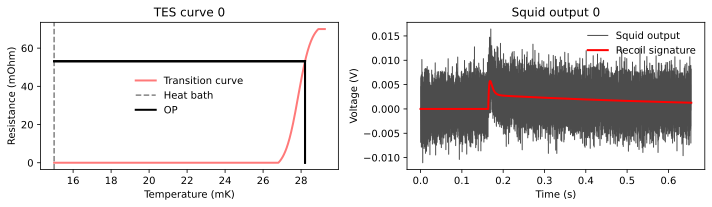

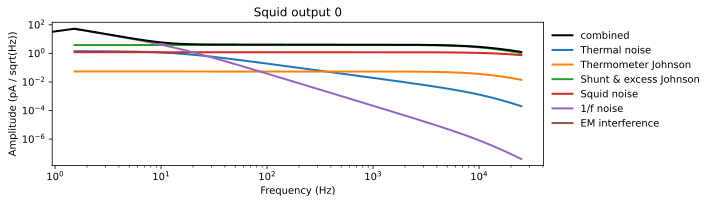

In [46]:
det.plot_temperatures()

det.plot_tes() 

det.plot_nps()  

In [47]:
print(det.T[0,0])

28.205499287935737


In [48]:
therm_max = np.max(det.T[:,0]) - det.T[0,0]
abs_max = np.max(det.T[:,1]) - det.T[0,1]
print('therm_max, abs_max = ', therm_max, abs_max) 

therm_max, abs_max =  0.004349390345122828 0.003952994873962723


In [49]:
_, tau_in_, tau_t_ = det.get_thermal_time_constants()
print('tau_in_, tau_t_ = ', tau_in_, tau_t_)
print('f_c_in_, f_c_t_ = ', 1/(2*tau_in_*np.pi), 1/(2*tau_t_*np.pi))

tau_in_, tau_t_ =  0.0055454761067617805 0.6017646988358798
f_c_in_, f_c_t_ =  28.69996011664941 0.26448035818615195


In [50]:
An_, At_, An_a_, At_a_ = det.get_thermal_amplitudes(er=60.)
print('An_, At_, An_a_, At_a_ = ', An_, At_, An_a_, At_a_)

An_, At_, An_a_, At_a_ =  -0.08803553202294562 0.0216270622658065 0.0010934897670314596 0.040673258890911765


In [51]:
print('Amplitude descrepancy thermometer: ', (An_ + At_)/therm_max)

Amplitude descrepancy thermometer:  -15.26845476897837


In [52]:
print('Amplitude descrepancy absorber: ', (An_a_ + At_a_)/abs_max)

Amplitude descrepancy absorber:  10.56584943558849


In [53]:
pulse = det.Il.flatten() - det.Il[0]
Tt = det.T[0, 0]
It = det.It[0, 0]
w, nps = det.get_nps(Tt, It)

In [54]:
pulse_fft = np.abs(np.fft.rfft(pulse)) ** 2
pulse_fft *= 2 / det.sample_frequency / det.sample_frequency  # need to argue this normalization!

In [55]:
print('SNR of optimally filtered 1 keV pulse: {:.3}'.format(np.sqrt(np.trapz(pulse_fft[1:]/6**2/nps[1:], w[1:]))))

SNR of optimally filtered 1 keV pulse: 2.43


In [56]:
print('Energy resolution, optimally filtered: {:.3} keV'.format(1/(np.sqrt(np.trapz(pulse_fft[1:]/6**2/nps[1:], w[1:])))))

Energy resolution, optimally filtered: 0.412 keV


## scaling props

In [57]:
pars_func_summer = {
    'er_keV':6., 
    'Ce_ref':0.00401248,
    'Ca_ref':0.23132998,
    'Geb':0.457, 
    'Gab':0.147,
    'Gae':0.51,
    'colleff_ref':0.04,
    'lamb_ref':0.00242, 
    'T_op':28.2, 
    'T_op_ref':28.2, 
    'Tb':15.,
    'tc':27.85,
    # 'R_target':0.053,
    'area_tes':2,  # area_tes would also include Al collectors
    'area_tes_ref':2,  
    'thickness_tes':1,  
    'thickness_tes_ref':1,  
    'vol_absorber':1000, 
    'vol_absorber_ref':1000, 
    'surf_absorber':600, 
    'surf_absorber_ref':600,
    'debye_temp':165000, 
    'debye_temp_ref':165000,
}

In [58]:
pars_det_summer = {
    'delta': np.array([[1., 0.]]),
    'delta_h': np.array([[1., 0.]]),
    'Rs': np.array([0.04]),
    'Rh': np.array([10.]),
    'L': np.array([1.3e-06]),
    'Rt0': np.array([0.07]),
    'k': np.array([2.857]),
    'Ib': np.array([1.]),
    'dac': np.array([1.88]),
    'pulser_scale': np.array([0.1]),
    'heater_current': np.array([2.]),
    'eta': np.array([6.66666667]),
    'tes_flag': np.array([ True, False]),
    'heater_flag': np.array([ True, False]),
    'i_sq': np.array([1.2]),
    'tes_fluct': np.array([0.009]),
    'flicker_slope': np.array([2.5]),
    'emi': np.array([[0., 0., 0.]]),
    'tau_cap': np.array([1.]),
    'Ib_range': (0.0, 17.86),
    'excess_johnson': np.array([2.]),
    'lowpass': 20000.0,
    'record_length': 32768,
    'sample_frequency': 50001,
    't0': 0.16384,
    'tp_interval': 10,
    'adjust_heatcap': False,
}

In [59]:
# do for 3.6, 28.8, 97.2 g crystals

pars_func_summer_4g = deepcopy(pars_func_summer)
pars_func_summer_4g['vol_absorber'] *= 1 ** 3
pars_func_summer_4g['surf_absorber'] *= 1 ** 2
pars_func_summer_4g['Gab'] *= 1 ** 2

pars_func_summer_29g = deepcopy(pars_func_summer)
pars_func_summer_29g['vol_absorber'] *= 2 ** 3
pars_func_summer_29g['surf_absorber'] *= 2 ** 2
pars_func_summer_29g['Gab'] *= 2 ** 2

pars_func_summer_97g = deepcopy(pars_func_summer)
pars_func_summer_97g['vol_absorber'] *= 3 ** 3
pars_func_summer_97g['surf_absorber'] *= 3 ** 2
pars_func_summer_97g['Gab'] *= 3 ** 2


## temperature down

In [59]:
all_op_temps_su = []

for setup in [pars_func_summer_4g, pars_func_summer_29g, pars_func_summer_97g]:
    op_temps = []
    for temp in tqdm(np.logspace(np.log10(17.), np.log10(33.), 30)):
        this_setup = deepcopy(setup)
        this_setup['T_op'] = temp
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(pars_det=pars_det_summer, **this_setup)
        op_temps.append([eres, tau_n, tau_in, tau_t, eps_])
    all_op_temps_su.append(op_temps)

all_op_temps_su = np.array(all_op_temps_su)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [60]:
np.save('plots_paper/run376_all_op_temps.npy', all_op_temps_su)

In [67]:
all_op_temps_su = np.load('plots_paper/run376_all_op_temps.npy')

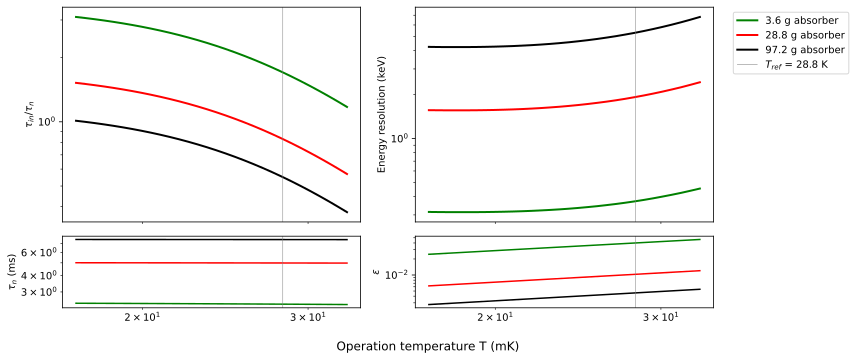

In [68]:
fig, axes = plt.subplots(2,2, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=300)

x_grid = np.logspace(np.log10(17.), np.log10(33.), 30)

axes[0,0].plot(x_grid, all_op_temps_su[0, :, 2]/all_op_temps_su[0, :, 1], color='green', linewidth=2.)
axes[0,0].plot(x_grid, all_op_temps_su[1, :, 2]/all_op_temps_su[1, :, 1], color='red', linewidth=2.)
axes[0,0].plot(x_grid, all_op_temps_su[2, :, 2]/all_op_temps_su[2, :, 1], color='black', linewidth=2.)
axes[0,0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].axvline(28.2, color='grey', linewidth=0.5)

axes[0,1].plot(x_grid, all_op_temps_su[0, :, 0], color='green', linewidth=2.,
            label="3.6 g absorber")
axes[0,1].plot(x_grid, all_op_temps_su[1, :, 0], color='red', linewidth=2.,
            label="28.8 g absorber")
axes[0,1].plot(x_grid, all_op_temps_su[2, :, 0], color='black', linewidth=2.,
            label="97.2 g absorber")
axes[0,1].set_ylabel('Energy resolution (keV)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].axvline(28.2, color='grey', linewidth=0.5, label='$T_{ref}$ = 28.8 K')
axes[0,1].legend(bbox_to_anchor=(1.05, 1.0))

axes[1,0].plot(x_grid, 1000*all_op_temps_su[0,:,1], color='green', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_op_temps_su[1,:,1], color='red', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_op_temps_su[2,:,1], color='black', linewidth=1.5)
axes[1,0].axvline(28.2, color='grey', linewidth=0.5)
axes[1,0].set_ylabel(r'$\tau_n$ (ms)')
axes[1,0].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].plot(x_grid, all_op_temps_su[0,:,-1], color='green', linewidth=1.5)
axes[1,1].plot(x_grid, all_op_temps_su[1,:,-1], color='red', linewidth=1.5)
axes[1,1].plot(x_grid, all_op_temps_su[2,:,-1], color='black', linewidth=1.5)
axes[1,1].axvline(28.2, color='grey', linewidth=0.5)
axes[1,1].set_ylabel(r'$\epsilon$')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')

fig.supxlabel(r'Operation temperature T (mK)')
# fig.suptitle(r"$\tau_n(T_{ref})$ = 2 ms, $C_{a}(T_{ref})$ = 0.038 pJ/mK, $C_{e}(T_{ref})$ = 0.001 pJ/mK, $G_{eb}(T_{ref})$ = 0.04 pW/mK, $G_{ab}(T_{ref})$ = 0.04 pW/mK, $G_{ae}(T_{ref})$ = 17.2 pW/mK, $\epsilon(T_{ref})$ = 0.2")
plt.tight_layout()
plt.savefig('plots_paper/run376_op_temps.png')
plt.show()


In [70]:
print('Resolution 4g in keV: ', all_op_temps_su[0, :, 0].min(), ' at ', x_grid[all_op_temps_su[0, :, 0].argmin()])
print('Resolution 29g in keV: ', all_op_temps_su[1, :, 0].min(), ' at ', x_grid[all_op_temps_su[1, :, 0].argmin()])
print('Resolution 97g in keV: ', all_op_temps_su[2, :, 0].min(), ' at ', x_grid[all_op_temps_su[2, :, 0].argmin()])

Resolution 4g in keV:  0.3132818195819597  at  18.628677633951593
Resolution 29g in keV:  1.560713471804314  at  18.2074342733497
Resolution 97g in keV:  4.233482038464617  at  18.2074342733497


## optimize gold size

In [72]:
# do for 3.6, 28.8, 97.2 g crystals

pars_func_summer_4g = deepcopy(pars_func_summer)
pars_func_summer_4g['vol_absorber'] *= 1 ** 3
pars_func_summer_4g['surf_absorber'] *= 1 ** 2
pars_func_summer_4g['T_op'] = 17. 
pars_func_summer_4g['Gab'] *= 1 ** 2

pars_func_summer_29g = deepcopy(pars_func_summer)
pars_func_summer_29g['vol_absorber'] *= 2 ** 3
pars_func_summer_29g['surf_absorber'] *= 2 ** 2
pars_func_summer_29g['T_op'] = 17.
pars_func_summer_29g['Gab'] *= 2 ** 2

pars_func_summer_97g = deepcopy(pars_func_summer)
pars_func_summer_97g['vol_absorber'] *= 3 ** 3
pars_func_summer_97g['surf_absorber'] *= 3 ** 2
pars_func_summer_97g['T_op'] = 17.
pars_func_summer_97g['Gab'] *= 3 ** 2


In [274]:
all_gold_sizes_su = []

for setup in [pars_func_summer_4g, pars_func_summer_29g, pars_func_summer_97g]:
    gold_sizes = []
    for aus in tqdm(np.logspace(np.log10(0.2), np.log10(400.), 30)):
        this_setup = deepcopy(setup)
        this_setup['area_tes'] = aus
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(pars_det=pars_det_summer, **this_setup)
        gold_sizes.append([eres, tau_n, tau_in, tau_t, eps_])
    all_gold_sizes_su.append(gold_sizes)

all_gold_sizes_su = np.array(all_gold_sizes_su)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [275]:
np.save('plots_paper/run376_all_gold_sizes.npy', all_gold_sizes_su)

In [73]:
all_gold_sizes_su = np.load('plots_paper/run376_all_gold_sizes.npy')

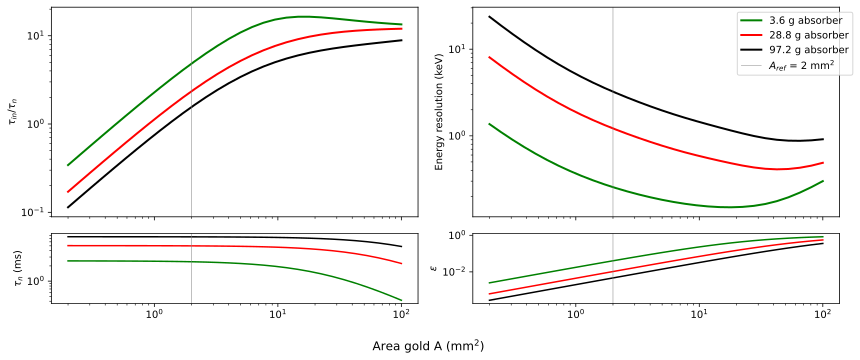

In [74]:
fig, axes = plt.subplots(2,2, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=300)

x_grid = np.logspace(np.log10(0.2), np.log10(100.), 30)

axes[0,0].plot(x_grid, all_gold_sizes_su[0, :, 2]/all_gold_sizes_su[0, :, 1], color='green', linewidth=2.)
axes[0,0].plot(x_grid, all_gold_sizes_su[1, :, 2]/all_gold_sizes_su[1, :, 1], color='red', linewidth=2.)
axes[0,0].plot(x_grid, all_gold_sizes_su[2, :, 2]/all_gold_sizes_su[2, :, 1], color='black', linewidth=2.)
axes[0,0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].axvline(2., color='grey', linewidth=0.5)

axes[0,1].plot(x_grid, all_gold_sizes_su[0, :, 0], color='green', linewidth=2.,
            label="3.6 g absorber")
axes[0,1].plot(x_grid, all_gold_sizes_su[1, :, 0], color='red', linewidth=2.,
            label="28.8 g absorber")
axes[0,1].plot(x_grid, all_gold_sizes_su[2, :, 0], color='black', linewidth=2.,
            label="97.2 g absorber")
axes[0,1].set_ylabel('Energy resolution (keV)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].axvline(2., color='grey', linewidth=0.5, label='$A_{ref}$ = 2 mm$^2$')
axes[0,1].legend(bbox_to_anchor=(1.05, 1.0))

axes[1,0].plot(x_grid, 1000*all_gold_sizes_su[0,:,1], color='green', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_gold_sizes_su[1,:,1], color='red', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_gold_sizes_su[2,:,1], color='black', linewidth=1.5)
axes[1,0].axvline(2., color='grey', linewidth=0.5)
axes[1,0].set_ylabel(r'$\tau_n$ (ms)')
axes[1,0].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].plot(x_grid, all_gold_sizes_su[0,:,-1], color='green', linewidth=1.5)
axes[1,1].plot(x_grid, all_gold_sizes_su[1,:,-1], color='red', linewidth=1.5)
axes[1,1].plot(x_grid, all_gold_sizes_su[2,:,-1], color='black', linewidth=1.5)
axes[1,1].axvline(2., color='grey', linewidth=0.5)
axes[1,1].set_ylabel(r'$\epsilon$')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')

fig.supxlabel(r'Area gold A (mm$^2$)')
# fig.suptitle(r"$\tau_n(T_{ref})$ = 2 ms, $C_{a}(T_{ref})$ = 0.038 pJ/mK, $C_{e}(T_{ref})$ = 0.001 pJ/mK, $G_{eb}(T_{ref})$ = 0.04 pW/mK, $G_{ab}(T_{ref})$ = 0.04 pW/mK, $G_{ae}(T_{ref})$ = 17.2 pW/mK, $\epsilon(T_{ref})$ = 0.2")
plt.tight_layout()
plt.savefig('plots_paper/run376_all_gold_sizes.png')
plt.show()


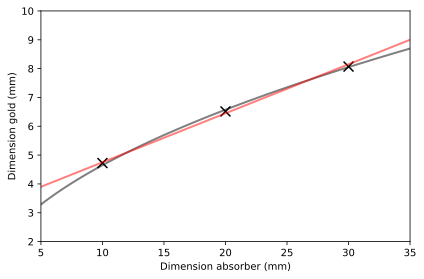

In [75]:
plt.figure(figsize=(6,4), dpi=300)
x_dims = np.array([10, 20, 30])
x_dims_grid = np.linspace(0,35,100)
plt.plot(x_dims_grid, 1.47*np.sqrt(x_dims_grid), color='black', alpha=0.5, linewidth=2)
plt.scatter(x_dims, np.sqrt([x_grid[22], x_grid[25], x_grid[27]]), marker='x', color='black', s=100)
plt.plot(x_dims_grid, 0.17*x_dims_grid + 3.05, color='red', alpha=0.5, linewidth=2)
plt.ylabel('Dimension gold (mm)')
plt.xlabel('Dimension absorber (mm)')
plt.xlim(5,35)
plt.ylim(2,10)
plt.savefig('plots_paper/run376_dimensions.png')
plt.tight_layout()
plt.show()

In [76]:
print('Resolution 4g in keV: ', all_gold_sizes_su[0, :, 0].min(), ' at ', x_grid[all_gold_sizes_su[0, :, 0].argmin()])
print('Resolution 29g in keV: ', all_gold_sizes_su[1, :, 0].min(), ' at ', x_grid[all_gold_sizes_su[1, :, 0].argmin()])
print('Resolution 97g in keV: ', all_gold_sizes_su[2, :, 0].min(), ' at ', x_grid[all_gold_sizes_su[2, :, 0].argmin()])

Resolution 4g in keV:  0.14974170225480232  at  18.007629661059447
Resolution 29g in keV:  0.4104860036557754  at  42.43539756036161
Resolution 97g in keV:  0.8760245606432245  at  65.14245739942696


## opt thickness TES

In [89]:
# do for 3.6, 28.8, 97.2 g crystals

pars_func_summer_4g = deepcopy(pars_func_summer)
pars_func_summer_4g['vol_absorber'] *= 1 ** 3
pars_func_summer_4g['surf_absorber'] *= 1 ** 2
pars_func_summer_4g['T_op'] = 17. 
pars_func_summer_4g['Gab'] *= 1 ** 2 
pars_func_summer_4g['area_tes'] = 18.

pars_func_summer_29g = deepcopy(pars_func_summer)
pars_func_summer_29g['vol_absorber'] *= 2 ** 3
pars_func_summer_29g['surf_absorber'] *= 2 ** 2
pars_func_summer_29g['T_op'] = 17. 
pars_func_summer_29g['Gab'] *= 2 ** 2 
pars_func_summer_29g['area_tes'] = 42. 

pars_func_summer_97g = deepcopy(pars_func_summer)
pars_func_summer_97g['vol_absorber'] *= 3 ** 3
pars_func_summer_97g['surf_absorber'] *= 3 ** 2
pars_func_summer_97g['T_op'] = 17. 
pars_func_summer_97g['Gab'] *= 3 ** 2 
pars_func_summer_97g['area_tes'] = 65.

In [284]:
all_thickness_su = []

for setup in [pars_func_summer_4g, pars_func_summer_29g, pars_func_summer_97g]:
    thickness = []
    for thick in tqdm(np.logspace(np.log10(0.1), np.log10(10.), 30)):
        this_setup = deepcopy(setup)
        this_setup['thickness_tes'] = thick
        eres, tau_n, tau_in, tau_t, eps_ = calc_resolution(pars_det=pars_det_summer, **this_setup)
        thickness.append([eres, tau_n, tau_in, tau_t, eps_])
    all_thickness_su.append(thickness)

all_thickness_su = np.array(all_thickness_su)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [285]:
np.save('plots_paper/run376_all_thickness.npy', all_thickness_su)

In [90]:
all_thickness_su = np.load('plots_paper/run376_all_thickness.npy')

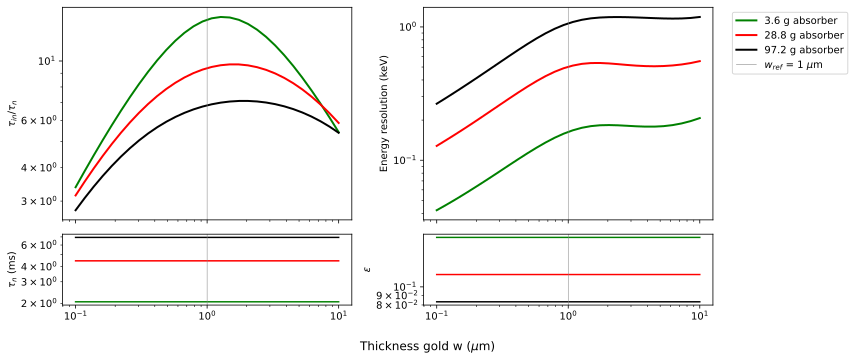

In [91]:
fig, axes = plt.subplots(2,2, figsize=(12,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]}, dpi=300)

x_grid = np.logspace(np.log10(0.1), np.log10(10.), 30)

axes[0,0].plot(x_grid, all_thickness_su[0, :, 2]/all_thickness_su[0, :, 1], color='green', linewidth=2.)
axes[0,0].plot(x_grid, all_thickness_su[1, :, 2]/all_thickness_su[1, :, 1], color='red', linewidth=2.)
axes[0,0].plot(x_grid, all_thickness_su[2, :, 2]/all_thickness_su[2, :, 1], color='black', linewidth=2.)
axes[0,0].set_ylabel(r'$\tau_{in} / \tau_{n}$')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].axvline(1., color='grey', linewidth=0.5)

axes[0,1].plot(x_grid, all_thickness_su[0, :, 0], color='green', linewidth=2.,
            label="3.6 g absorber")
axes[0,1].plot(x_grid, all_thickness_su[1, :, 0], color='red', linewidth=2.,
            label="28.8 g absorber")
axes[0,1].plot(x_grid, all_thickness_su[2, :, 0], color='black', linewidth=2.,
            label="97.2 g absorber")
axes[0,1].set_ylabel('Energy resolution (keV)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].axvline(1., color='grey', linewidth=0.5, label='$w_{ref}$ = 1 $\mu$m')
axes[0,1].legend(bbox_to_anchor=(1.05, 1.0))

axes[1,0].plot(x_grid, 1000*all_thickness_su[0,:,1], color='green', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_thickness_su[1,:,1], color='red', linewidth=1.5)
axes[1,0].plot(x_grid, 1000*all_thickness_su[2,:,1], color='black', linewidth=1.5)
axes[1,0].axvline(1., color='grey', linewidth=0.5)
axes[1,0].set_ylabel(r'$\tau_n$ (ms)')
axes[1,0].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].plot(x_grid, all_thickness_su[0,:,-1], color='green', linewidth=1.5)
axes[1,1].plot(x_grid, all_thickness_su[1,:,-1], color='red', linewidth=1.5)
axes[1,1].plot(x_grid, all_thickness_su[2,:,-1], color='black', linewidth=1.5)
axes[1,1].axvline(1., color='grey', linewidth=0.5)
axes[1,1].set_ylabel(r'$\epsilon$')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')

fig.supxlabel(r'Thickness gold w ($\mu$m)')
# fig.suptitle(r"$\tau_n(T_{ref})$ = 2 ms, $C_{a}(T_{ref})$ = 0.038 pJ/mK, $C_{e}(T_{ref})$ = 0.001 pJ/mK, $G_{eb}(T_{ref})$ = 0.04 pW/mK, $G_{ab}(T_{ref})$ = 0.04 pW/mK, $G_{ae}(T_{ref})$ = 17.2 pW/mK, $\epsilon(T_{ref})$ = 0.2")
plt.tight_layout()
plt.savefig('plots_paper/run376_all_thickness.png')
plt.show()


In [81]:
print('Resolution 4g in keV: ', all_thickness_su[0, :, 0].min(), ' at ', x_grid[all_thickness_su[0, :, 0].argmin()])
print('Resolution 29g in keV: ', all_thickness_su[1, :, 0].min(), ' at ', x_grid[all_thickness_su[1, :, 0].argmin()])
print('Resolution 97g in keV: ', all_thickness_su[2, :, 0].min(), ' at ', x_grid[all_thickness_su[2, :, 0].argmin()])

Resolution 4g in keV:  0.0421760003991788  at  0.1
Resolution 29g in keV:  0.12809369234088278  at  0.1
Resolution 97g in keV:  0.2653878850501864  at  0.1


T0 is [17.0000979  15.62573925] mK.
Calculated in 0.332744836807251 s.
Generated noise in 0.012858152389526367 s.


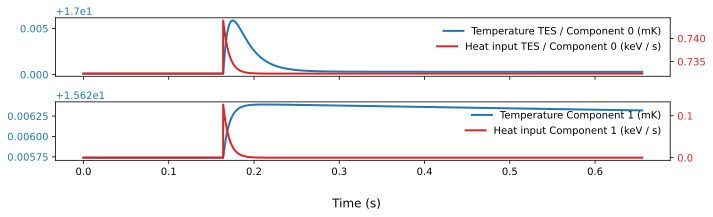

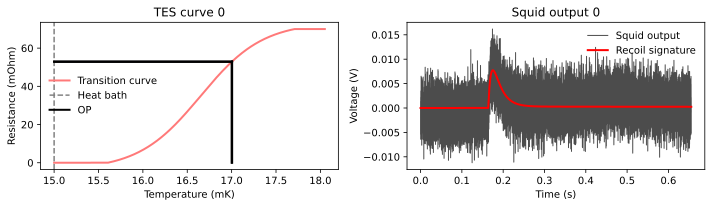

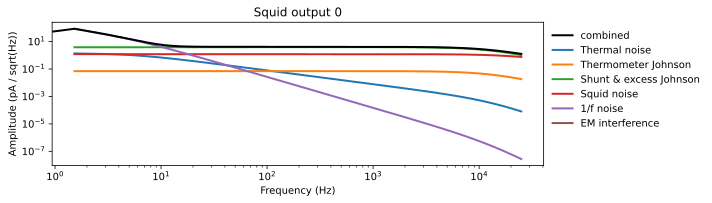

(0.2653878850501864,
 0.0069335912217589595,
 0.01922946774259888,
 3.610852511426236,
 0.08316149133765822)

In [82]:
this_setup = deepcopy(pars_func_summer_97g)
this_setup['thickness_tes'] = 0.1

calc_resolution(pars_det=pars_det_summer, do_plot=True, **this_setup)